In this notebook we would like to see how the classifier behaves when predicting labels starting from data obtained by our phone. We expect some problems due to the phone difference (IPhone 6 vs Honor 20), sensors sensitivity and scaling.
Let's see what we can do.

In [278]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [279]:
df_train=pd.read_csv("../collapsed_datasets/deviceMotion_3secs.csv").drop("Unnamed: 0", axis=1)
corr_matrix = df_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
non_corr_df_train=df_train.drop(to_drop, axis=1)

X_train=non_corr_df_train.drop("class", axis=1)
y_train=non_corr_df_train["class"]

df_test=pd.read_csv("../collapsed_datasets/honor_ds_3secs_original.csv")
df_test=df_test.drop("Unnamed: 0", axis=1)
non_corr_df_test=df_test.drop(to_drop, axis=1)

X_test=non_corr_df_test.drop("class", axis=1)
y_test=non_corr_df_test["class"]

C:\Users\marco\AppData\Local\Temp\ipykernel_25724\3426839197.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_train.corr().abs()
C:\Users\marco\AppData\Local\Temp\ipykernel_25724\3426839197.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


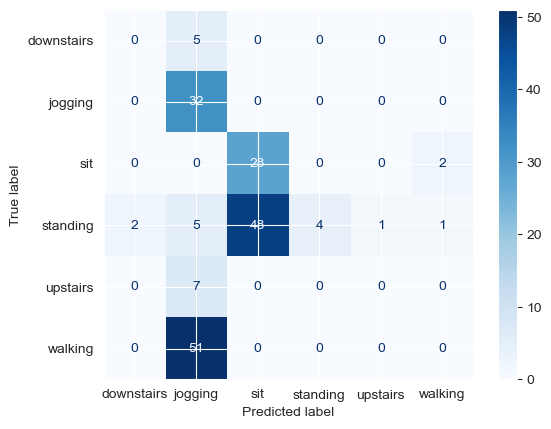

In [280]:
from sklearn.feature_selection import SelectKBest
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

ranfor_pipe=Pipeline([
    ("scaler", RobustScaler()),
    ("sampling", SMOTE()),
    ("feature-selector", SelectKBest(k=8)),
    ("classifier", RandomForestClassifier(n_jobs=-1))
])

ranfor_pipe.fit(X_train, y_train)
y_pred = ranfor_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=df_train["class"].unique(), cmap=plt.cm.Blues)

[Text(0.5, 0, 'Dataset'), Text(0, 0.5, 'Accuracy')]

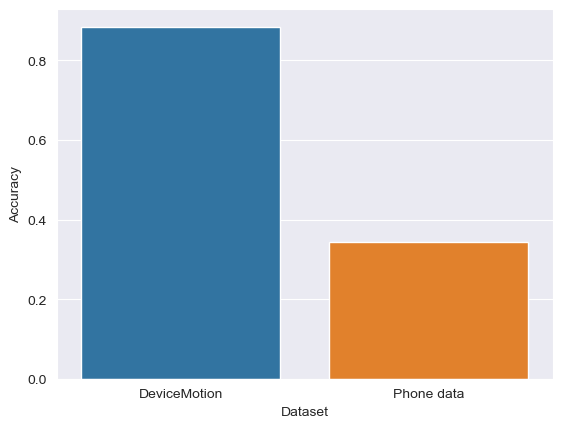

In [281]:
from sklearn.model_selection import train_test_split
import seaborn as sns

count=0
for i in range(0, y_pred.size):
    if y_pred[i]==y_test[i]:
        count+=1
acc_phone=count/y_pred.size

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, shuffle=True, random_state=42)
ranfor_pipe.fit(X_train, y_train)
y_pred = ranfor_pipe.predict(X_test)
count=0
for true, predicted in zip(y_test, y_pred):
    if true==predicted:
        count+=1
acc=count/y_pred.size

ax=sns.barplot(x=["DeviceMotion","Phone data"], y=[acc, acc_phone])
ax.set(xlabel="Dataset", ylabel="Accuracy")



We can easily see that the data obtained by our phone is often misclassified, obtaining a really low accuracy compared to the score obtained classifying only readings coming from the DeviceMotion dataset.
Looking at the confusion matrix we can see the most relevant miss classifications. In particular standing is always recognized as sitting, walking as jogging, and upstairs and downstairs are never recognized properly.
Why do we obtain those poor results? Let's take a look at jogging into the 2 different datasets, to compare the signals.

In [282]:
df_jog_deviceMotion=pd.read_csv("../A_DeviceMotion_data/jog_9/sub_1.csv").drop(["Unnamed: 0", "attitude.roll", "attitude.pitch", "attitude.yaw", "gravity.x", "gravity.y", "gravity.z"], axis=1)[100:400]
df_jog_honor=pd.read_csv("../honor20readings_original/dataset_honor20_jogging1.csv").drop("class", axis=1)[100:400]

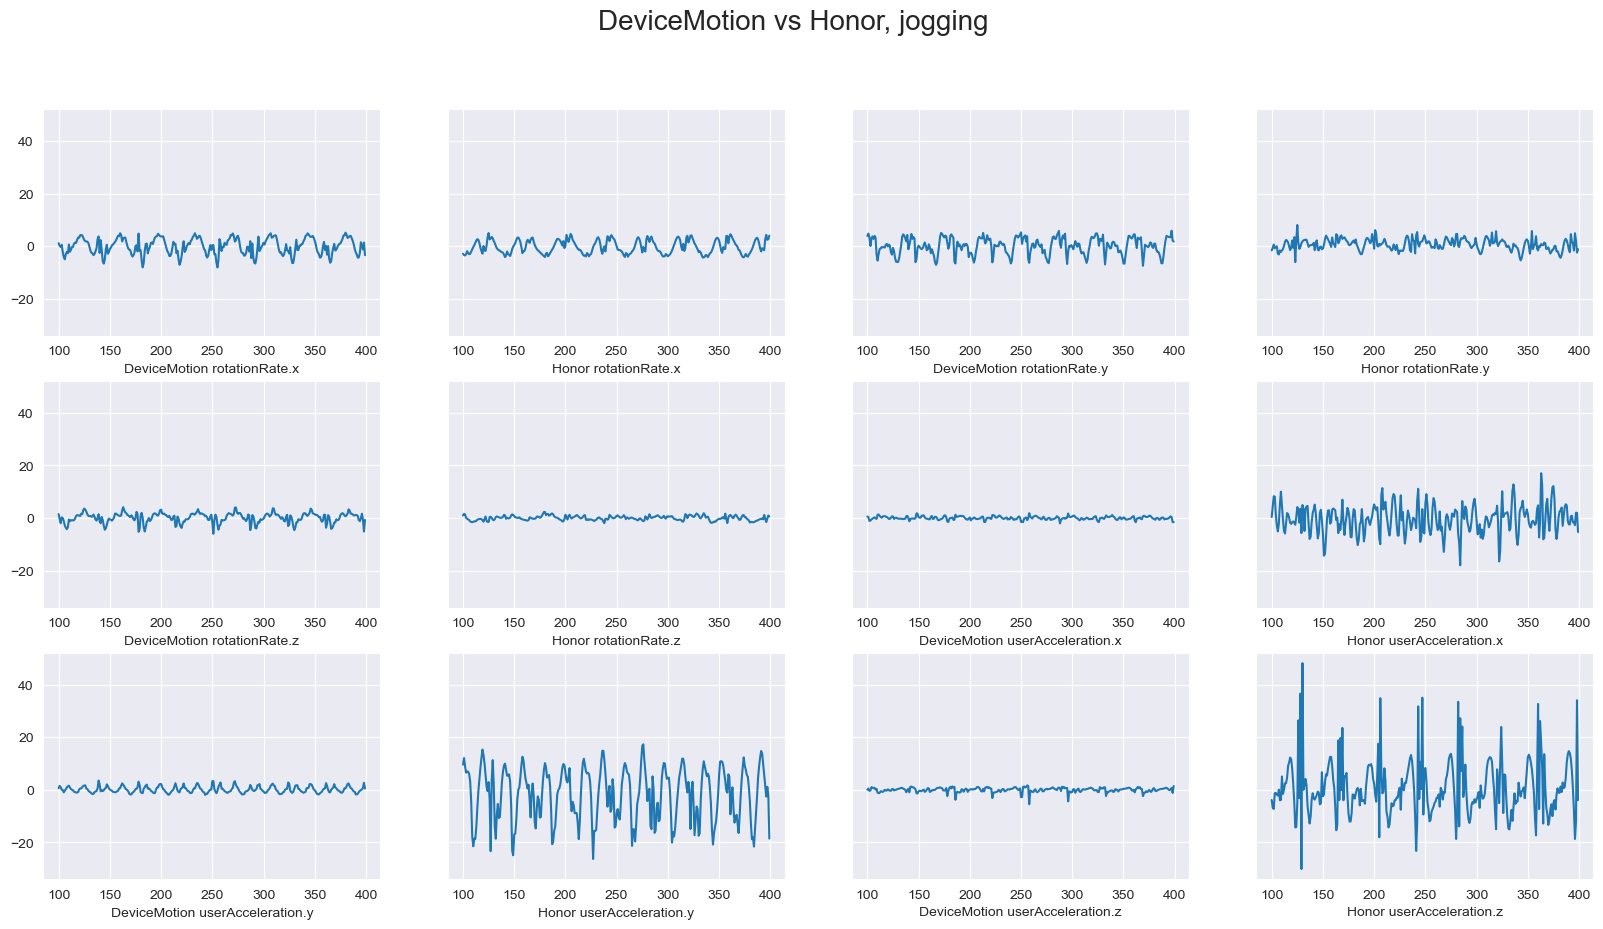

In [283]:
f, axes=plt.subplots(3, 4, figsize=(20,10), sharey=True)
f.suptitle("DeviceMotion vs Honor, jogging", fontsize=20)
i=0
j=0
for column in df_jog_deviceMotion:
    axes[i][j].plot(df_jog_deviceMotion[column])
    axes[i][j].set_xlabel("DeviceMotion "+column)
    j+=1
    axes[i][j].plot(df_jog_honor[column])
    axes[i][j].set_xlabel("Honor "+column)
    if j==3:
        j=0
        i+=1
    else: j+=1

We see that the problem seems to be in rotation.z, where the honor readings have a lower range, and in userAcceleration.x,y,z, where instead the honor readings have a much higher range. Let's see what happens if we try to correct them by multiplying or dividing.

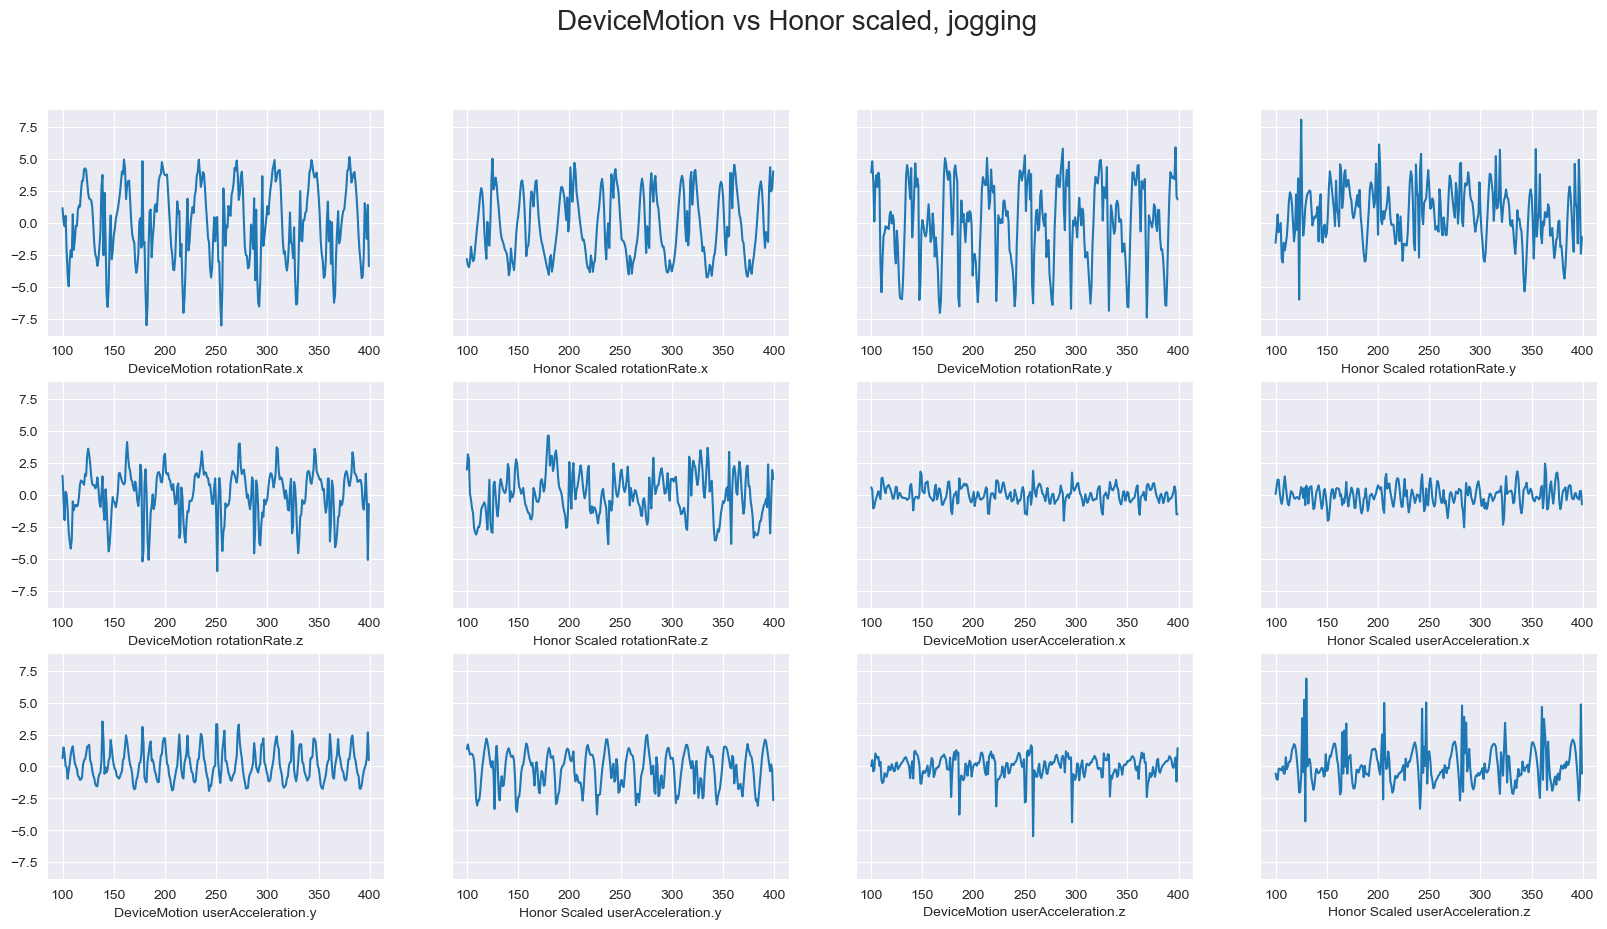

In [284]:
df_jog_honor_scaled = pd.read_csv("../honor20readings/dataset_honor20_jogging1.csv").drop("class", axis=1)[100:400]
f, axes=plt.subplots(3, 4, figsize=(20,10), sharey=True)
f.suptitle("DeviceMotion vs Honor scaled, jogging", fontsize=20)
i=0
j=0
for column in df_jog_deviceMotion:
    axes[i][j].plot(df_jog_deviceMotion[column])
    axes[i][j].set_xlabel("DeviceMotion "+column)
    j+=1
    axes[i][j].plot(df_jog_honor_scaled[column])
    axes[i][j].set_xlabel("Honor Scaled "+column)
    if j==3:
        j=0
        i+=1
    else: j+=1

Now that the signals seems to be more similar, let's try to classify them again.

In [285]:
df_honor_scaled=pd.read_csv("../collapsed_datasets/honor_ds_3secs.csv").drop("Unnamed: 0", axis=1).drop(to_drop, axis=1)

[Text(0.5, 0, 'Dataset'), Text(0, 0.5, 'Accuracy')]

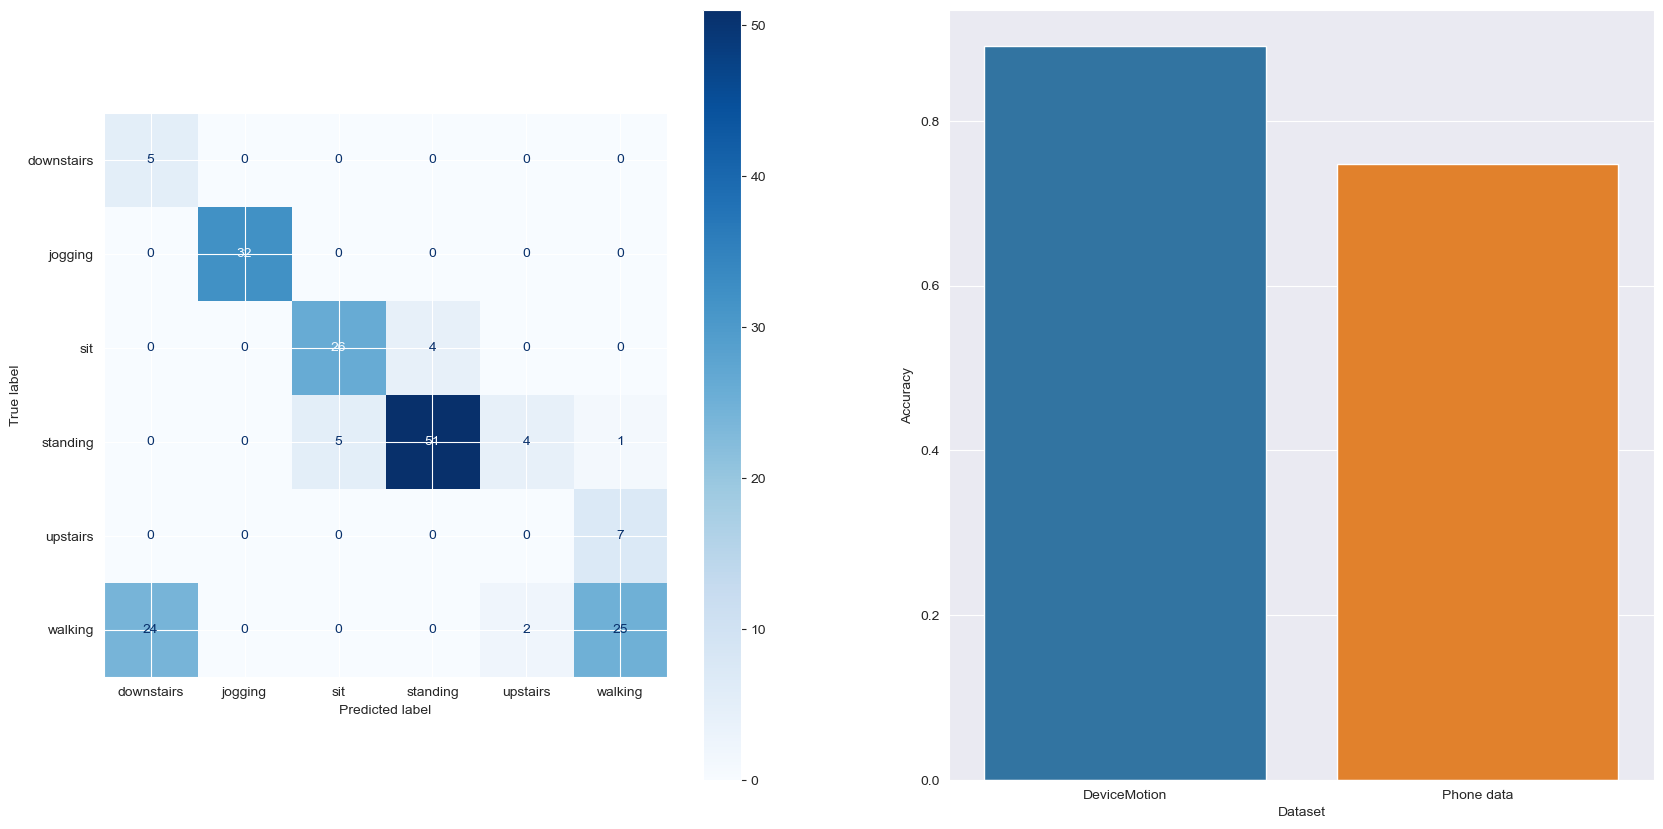

In [286]:
X_test = df_honor_scaled.drop("class", axis=1)
y_test = df_honor_scaled["class"]
ranfor_pipe.fit(X_train, y_train)
y_pred = ranfor_pipe.predict(X_test)
f, axes=plt.subplots(1,2,figsize=(20,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=df_train["class"].unique(), cmap=plt.cm.Blues, ax=axes[0])
count=0
for i in range(0, y_pred.size):
    if y_pred[i]==y_test[i]:
        count+=1
acc_phone=count/y_pred.size

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, shuffle=True, random_state=42)
ranfor_pipe.fit(X_train, y_train)
y_pred = ranfor_pipe.predict(X_test)
count=0
for true, predicted in zip(y_test, y_pred):
    if true==predicted:
        count+=1
acc=count/y_pred.size

ax=sns.barplot(x=["DeviceMotion","Phone data"], y=[acc, acc_phone], ax=axes[1])
ax.set(xlabel="Dataset", ylabel="Accuracy")

The barplot tells us that we obtain much better results, but there's still room to improve. In particular now we're able to discriminate between walking and jogging, and between standing and sitting. Also downstairs is classified as it should. The problem is that out of 51 walking samples, 20 of them were misclassified as downstairs, and upstairs was never recognized, being confused with walking.